# Important Note
Before going through the notebook, please refer to the README.md file for important instructions about the notebook and data

# Import Required libraries

In [1]:
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import fim
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the Data

In [2]:
import pandas as pd
df = pd.read_csv("sl_orders.csv", parse_dates=True, low_memory=False)
display(df.head())
display(HTML("<center><i>Table 1. Dataset Preview</i></center>"))

,Unnamed: 0.1,Unnamed: 0,Name,Paid at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,...,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Payment ID,Payment Terms Name,Next Payment Due At,Payment References
0,0,0,#8177,2024-02-15 10:55:25 +0530,no,INR,4800.0,700.0,139.81,5500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,rv1aNObeEz15kTvgvP7lqGOpr,NaN,NaN,rv1aNObeEz15kTvgvP7lqGOpr + x1EIiy3wXArrAcMmKx...
1,1,1,#8176,2024-02-14 13:11:57 +0530,yes,INR,2520.0,0.0,73.40,2520.0,...,NaN,NaN,NaN,NaN,NaN,NaN,rSo9NIJNwwxPd6EXrGB9DciPl,NaN,NaN,rSo9NIJNwwxPd6EXrGB9DciPl
2,2,2,#8175,2024-02-14 12:54:31 +0530,yes,INR,1280.0,0.0,37.28,1280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,rtEiFmdnHYy9pqg9mw4FKMLma,NaN,NaN,rtEiFmdnHYy9pqg9mw4FKMLma
3,3,3,#8174,2024-02-14 02:48:27 +0530,no,INR,8.0,0.0,0.23,8.0,...,NaN,NaN,NaN,9.199714e+11,NaN,NaN,r0uPHP4eWrBzBL0Il1ZoXCOm9,NaN,NaN,r0uPHP4eWrBzBL0Il1ZoXCOm9
4,4,4,#8173,2024-02-13 16:38:38 +0530,yes,INR,2808.0,0.0,81.79,2808.0,...,NaN,NaN,NaN,NaN,NaN,NaN,rsHJLQcT8RSMspSEGQBrdGTmy,NaN,NaN,rsHJLQcT8RSMspSEGQBrdGTmy


# Data exploration

During the examination of item names and SKUs, NaN (Not a Number) values were discovered, indicating missing information. Upon consultation with the business owners, it was revealed that these discrepancies were attributable to errors in the encoding process of the SKUs. Consequently, the `Lineitem name` field was identified as a more reliable source for item identification in transactions.

In [3]:
df[['Name', 'Paid at',"Lineitem name",'Lineitem sku']].isna().sum()

Name                0
Paid at          5406
Lineitem name       0
Lineitem sku      157
dtype: int64

`Figure 1` shows the total sales count of individual products. It can be seen that Classic Floral stands out, alongside the Saree Pin and Swaying and Graceful-silver, already we can see an initial offering of perhaps products that might be bundled together given their popularity relative to sales.  

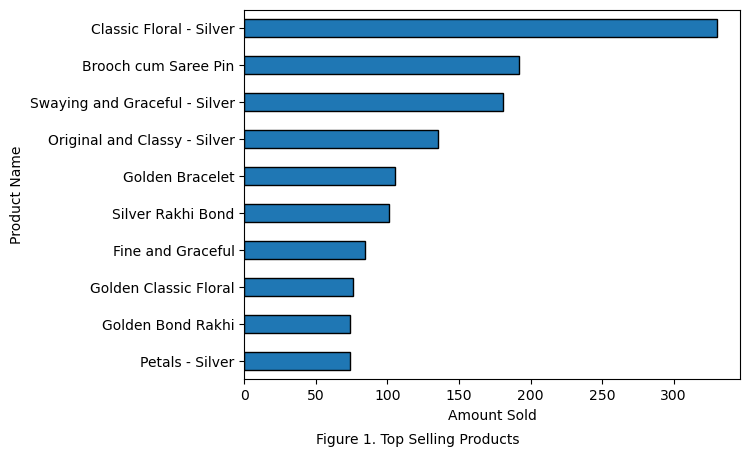

In [4]:
df["Lineitem name"].value_counts()[:10][::-1].plot(
    kind="barh", edgecolor="black",
)
plt.xlabel('Amount Sold')
plt.ylabel('Product Name')
plt.text(50, -2.25, 'Figure 1. Top Selling Products');

In `Figure 2`, the sales data across time were plotted, revealing that in instances where a user purchased multiple items in a single transaction, only the data for the first item were considered, leading to the exclusion of subsequent items from being recognized as purchased on the same date. To address this issue, a forward fill method was employed, ensuring that all items in a transaction were accurately indicated as being paid for on the same date, thereby including them in the distribution analysis.

Following this adjustment, a more accurate plot of the company's sales over time was produced. Notably, a significant spike in sales was observed during the sixth, seventh, and eighth months, a pattern that was consistent across several years, with the exception of 2020. In 2020, although a similar pattern was noticeable, the volume of sales was markedly lower, which could be attributed to the impact of the Global Pandemic during that period. This analysis suggests that while seasonal trends significantly influence the sales of the company, external factors such as global events can have a profound effect on consumer behavior and overall sales performance.

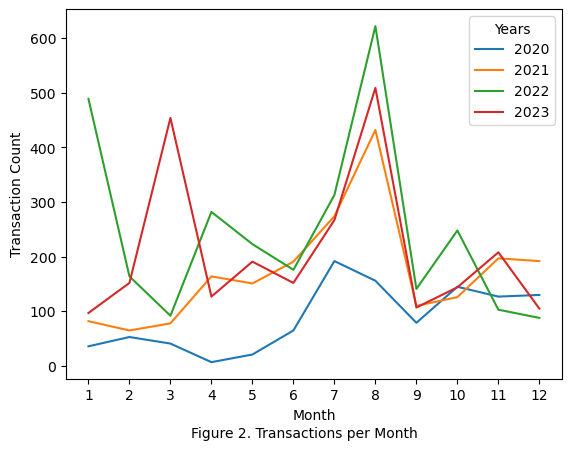

In [5]:
df["Paid at"] = pd.to_datetime(df["Paid at"])
df["Paid at"] = df["Paid at"].dt.strftime("%Y-%m")
df["Paid at"].ffill(inplace=True)
fig, ax = plt.subplots()
labels = []
for i in range(2020, 2024):
    globals()[f"df_{i}"] = df.loc[
        np.where(df["Paid at"].str.contains(str(i)) == True)
    ]
    globals()[f"df_{i}"]["Paid at"].value_counts().sort_index().plot(ax=ax)

    labels.append(str(i))
ax.set_xticks(np.arange(0, 12))
ax.set_xticklabels([str(month) for month in range(1, 13)])

ax.legend(labels, title="Years")
ax.set_xlabel("Month")
ax.set_ylabel('Transaction Count')
plt.text(2.5, -130, 'Figure 2. Transactions per Month');

# Data preprocessing

It was known through conversations with the business that there were several dummy values still contained within the data, as it contained all their transactions including their test transactions when they were establishing their database.  The cell below removes these dummy  values to ensure the data contains only actual transactions from customers.

In [6]:
index_dummy = (
    df["Lineitem name"].str.extract(r"(?i)(dummy)").dropna().index.tolist()
)
index_test = (
    df["Lineitem name"].str.extract(r"(?i)(test)").dropna().index.tolist()
)
index_dummy.extend(index_test)
df.drop(index=index_dummy, inplace=True)

Several products contained an extra label indicating them as variants of the main product, such as the top product ‘Classic Floral – Silver'. The purpose of removing this to simply offer a more robust offering to the customer and to the business. On the website of the company should a product have variants, customers will have the choices available to them on the page of the specific product should they examine it

In [7]:
df["Lineitem name"] = df["Lineitem name"].apply(
    lambda x: x.split("(")[0].split("-")[0].strip()
)

Due to the observed spike in sales across the years, the dataset was split into three parts. First, the data was considered as a whole. The second part were those months that contained the spike were referred to as the **peak season**, while those outside of this were referred to as the **regular season**.
 
Peak Season - The  period is commonly known as the Peak season, which holds significance primarily due to its association with religious observances and wedding ceremonies within the country. These occasions directly impact the demand for jewelry, as it is frequently exchanged as gifts during large family gatherings and purchased extensively for ceremonial wear. Consequently, this leads to a substantial surge in sales, contributing significantly to the business's overall performance during this period. 

Normal season – During a normal season, while there may not be as many significant religious or wedding festivities, there remains a steady demand for jewelry. This demand is driven by various factors such as personal milestones, everyday celebrations, and the timeless appeal of jewelry as a form of self-expression and adornment. Although the sales may not reach the same peaks as during peak seasons, they provide a consistent flow of revenue that sustains the business throughout the year.

In [8]:
df_678 = df.iloc[np.where(df["Paid at"].str.contains(r"\d{4}-0[678]") == True)]
df_others = df.drop(df_678.index)

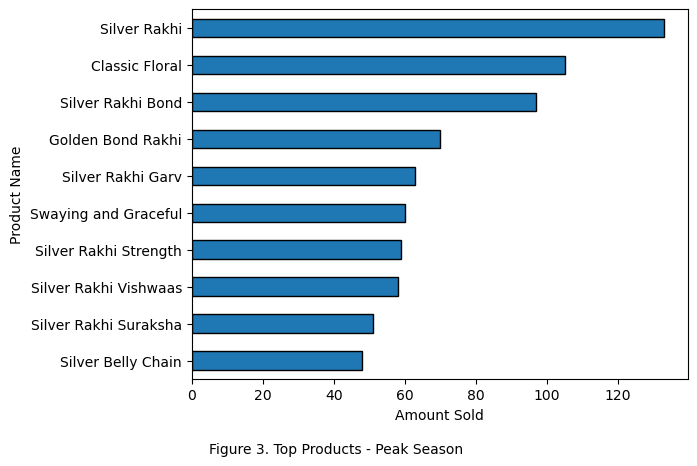

In [9]:
df_678["Lineitem name"].value_counts()[:10][::-1].plot(
    kind="barh", edgecolor="black"
)
plt.xlabel('Amount Sold')
plt.ylabel('Product Name');
plt.text(5, -2.5, 'Figure 3. Top Products - Peak Season');

The split data was examined to observe the distribution of products and their respective sales numbers. It was observed that classic floral was constant between the seasons, however during the peak season eight out of ten products were of the Silver Rakhi product line.  On the other hand the standard season showed more varied products. 

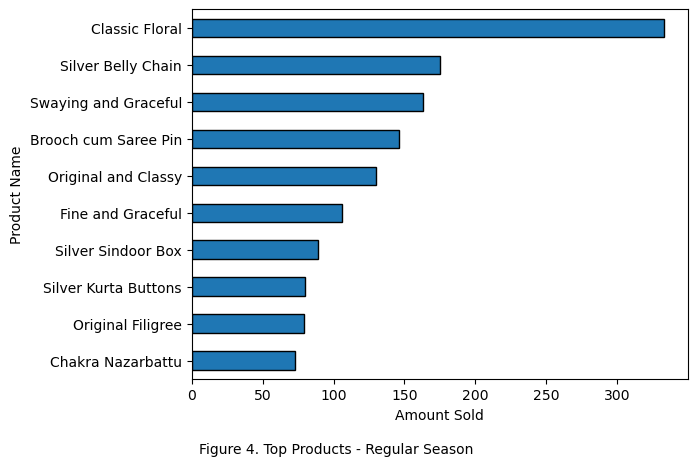

In [10]:
df_others["Lineitem name"].value_counts()[:10][::-1].plot(
    kind="barh", edgecolor="black"
)
plt.xlabel('Amount Sold')
plt.ylabel('Product Name');
plt.text(5, -2.5, 'Figure 4. Top Products - Regular Season');

The three seasons were stored in three seperate dataframes labeled: `df_itemset`,  `df_in_season` and `df_off_season`.

In [11]:
df_itemset = df.groupby("Name")["Lineitem name"].apply(set).to_frame()
df_in_season = df_678.groupby("Name")["Lineitem name"].apply(set).to_frame()
df_off_season = (
    df_others.groupby("Name")["Lineitem name"].apply(set).to_frame()
)

# Frequent itemset Mining Implementation

The maximal frequency sets of the peak season were taken with the use of the pyfim package. The hyperparameters used were `target="m"` to return the those sets of maximal frequency, a minimum of `-5` supports were set as the threshold with the negative indicating the absolute number of transactions. The `zmin=2` ensures that the minimum items contained must be two.  

In this example the support was set to 5 because it covered the peak season which is one quarter. However, upon consultation with the company, it was communicated that their business considered a good sale to be five sales per item.  

To ensure all itemsets could be viewed, the dataframe viewing options were set to ‘None’ to prevent truncation of rows and columns. 

In [12]:
max_sets_in = pd.DataFrame(
    fim.fpgrowth(
        df_in_season["Lineitem name"].apply(list), 
        target="m", 
        supp=-5, 
        zmin=2
    ),
    columns=["Itemset", "Support"],
)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(HTML(f"<center>{max_sets_in.to_html()}" "<i>Table 2 - Peak Season</i></center>"))

,Itemset,Support
0,"(Golden Rakhi Vows, Golden Bond Rakhi)",5
1,"(Silver Rakhi Loyal, Silver Rakhi Suraksha)",5
2,"(Rakhi Nanhe Phool, Silver Rakhi Unity)",6
3,"(Rakhi Nanhe Phool, Silver Rakhi Strength)",6
4,"(Bold and Beautiful, Original and Classy)",5
5,"(Leaf Nazarbattu, Chakra Nazarbattu)",5
6,"(Rakhi Nanhe Shaitan, Silver Rakhi Garv)",5
7,"(Fine and Graceful, Swaying and Graceful)",5
8,"(Swaying and Leafy, Classic Floral)",5
9,"(Mesmerising Tarakasi, Original and Classy)",5


The maximal frequency sets of the standard season were taken with the use of the pyfim package. The hyperparameters used were `target="m"` to return the those sets of maximal frequency, a minimum of `-15` supports were set as the threshold with the negative indicating the absolute number of transactions. The `zmin=2` ensures that the minimum items contained must be two.  

In this example the support was set to 15 because it covered the regular season which is three quarters.To ensure all itemsets could be viewed, the dataframe viewing options were set to ‘None’ to prevent truncation of rows and columns. 

In [13]:
max_sets_off = pd.DataFrame(
    fim.fpgrowth(
        df_off_season["Lineitem name"].apply(list),
        target="m",
        supp=-15,
        zmin=2,
    ),
    columns=["Itemset", "Support"],
)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(
        HTML(f"<center>{max_sets_off.to_html()}" "<i>Table 3 - Regular Season</i></center>")
    )

,Itemset,Support
0,"(Math is Fun, Swaying and Graceful)",16
1,"(Fine and Graceful, Classic Floral)",21
2,"(Chandbali Mini, Silver Filigree Hoops)",15
3,"(Chandbali Mini, Chakra Nazarbattu)",15
4,"(Petals, Original and Classy)",17
5,"(Black thread Nazar Battu, Leaf Nazarbattu)",15
6,"(Black thread Nazar Battu, Chakra Nazarbattu)",15
7,"(Heart Nazar battu, Leaf Nazarbattu, Chakra Nazarbattu)",15
8,"(Bead Dangles, Silver Filigree Hoops, Leaf Nazarbattu, Chakra Nazarbattu)",15
9,"(Bead Dangles, Original and Classy)",15


For the entire dataset, the support considered a four quarter year at ‘-20’ and a confidence of 75 to account for risk of the peak season but also the stability of the regular season. 

In [14]:
max_sets = pd.DataFrame(
    fim.fpgrowth(
        df_itemset["Lineitem name"].apply(list), target="m", supp=-20, zmin=2
    ),
    columns=["Itemset", "Support"],
)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(HTML(f"<center>{max_sets.to_html()}" "<i>Table 4 - Full Season</i></center>"))

,Itemset,Support
0,"(Math is Fun, Swaying and Graceful)",20
1,"(Fine and Graceful, Classic Floral)",24
2,"(Heart Nazar battu, Leaf Nazarbattu)",20
3,"(Bead Dangles, Leaf Nazarbattu)",20
4,"(Bead Dangles, Chakra Nazarbattu)",20
5,"(Silver Filigree Hoops, Leaf Nazarbattu, Chakra Nazarbattu)",20
6,"(Silver Filigree Hoops, Swaying and Graceful)",20
7,"(Chakra Nazarbattu, Original and Classy)",22
8,"(Original and Classy, Classic Floral)",20
9,"(Original and Classy, Swaying and Graceful)",31


# Results


For each season, both the minimum support thresholds and confidence levels were adjusted. This strategy was informed by discussions with the business, which indicated that selling an item five times within a quarter was deemed satisfactory. Consequently, the year was divided into four quarters, and for the **peak** season—which aligns with a single quarter—the minimum support threshold was established at five. The confidence level was set at 60% to mitigate the risk associated with creating bundles overly tailored to the festive season, ensuring that the product offerings remain balanced and reflective of broader consumer interests throughout the year.

Given the relatively low threshold for supports, combined with four years of sales data, a substantial number of bundles were generated. Notably, the Lift values of the top 10 bundles are exceptionally high, with the highest reaching 374.26 for the foremost bundle. This significant figure suggests that customers are 370 times more likely to purchase the items 'Ball Earrings' and 'Chakra Nazarbattu, Original and Classy' together, as opposed to purchasing them separately. This insight underscores a strong associative purchasing behavior among customers, specifically for these items, highlighting their potential as a combined offering to capitalize on during targeted sales strategies.

In [15]:
bundles_in_season = pd.DataFrame(
    [
        ((sorted(rules[1] + tuple([rules[0]])), rules[2]))
        for rules in sorted(
            fim.fpgrowth(
                df_in_season["Lineitem name"].apply(list),
                target="r",
                supp=-5,
                conf=60,
                report="l",
            ),
            key=lambda x: (-x[2], x[0], min(x[1])),
        )
    ],
    columns=["Bundles", "Lift"],
)
bundles_in_season = bundles_in_season.loc[
    bundles_in_season.Bundles.drop_duplicates().index
].reset_index(drop=True)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(
        HTML(
            f"<center>{bundles_in_season.to_html()}" "<i>Table 5 - In Season bundles</i></center>"
        )
    )

,Bundles,Lift
0,"[Balls Earrings, Chakra Nazarbattu, Original and Classy]",374.266667
1,"[Balls Earrings, Chakra Nazarbattu, Leaf Nazarbattu]",336.840000
2,"[Balls Earrings, Bead Dangles]",280.700000
3,"[Balls Earrings, Silver Filigree Hoops]",280.700000
4,"[Chakra Nazarbattu, Leaf Nazarbattu, Silver Filigree Hoops]",280.700000
5,"[Bead Dangles, Chakra Nazarbattu, Leaf Nazarbattu]",210.525000
6,"[Chakra Nazarbattu, Chakri Juda Pin, Leaf Nazarbattu]",210.525000
7,"[Lotus Studs, Mesmerising Tarakasi, Original and Classy]",187.133333
8,"[Balls Earrings, Mini Jhumki]",187.133333
9,"[Chakra Nazarbattu, Leaf Nazarbattu, Mini Jhumki]",187.133333


Despite the remarkably high Lift value observed, a closer inspection of the sales volume for this top-performing bundle revealed a limitation. The minimum support threshold was established at 5, yet any attempt to exceed this threshold did not yield additional bundles, indicating that, throughout four years of collected data, these bundles were sold merely five times. Further analysis revealed that these transactions were confined to the most recent year, 2023. This temporal concentration of sales means that, according to the criteria defined by the business, these sales volumes qualify as good. This scenario highlights the nuanced nature of data analysis, where high associative strength between items (as indicated by Lift) must be contextualized with actual sales performance and temporal trends to fully understand their significance and potential for future sales strategies.

Such a finding had several possible explanations. The first was that the company was relatively young, having only started in 2017 and then having to face a global pandemic a few years later. Add to the fact that jewelry is a luxury product, and people tend not buy it in bulk. Instead, as observed by the initial data exploration, there were many sales for solo pieces like the Classic Floral line which has contributed as the top seller over the years years, that would not appear in bigger bundles usually being paired with one other item.

As for the regular season, the top bundles were closer to expectations with one of the top sellers, Original and Classy, being in the top bundle, but also the presence of other popular items as well. The support was set here at 15, and beyond such did not yield results. Which meant that at least within their quarters in the last few years, the bundles were selling well by the business's standards even when considering the pandemic's effects.

In [16]:
bundles_off_season = pd.DataFrame(
    [
        ((sorted(rules[1] + tuple([rules[0]])), rules[2]))
        for rules in sorted(
            fim.fpgrowth(
                df_off_season["Lineitem name"].apply(list),
                target="r",
                supp=-15,
                conf=85,
                report="l",
            ),
            key=lambda x: (-x[2], x[0], min(x[1])),
        )
    ],
    columns=["Bundles", "Lift"],
)
bundles_off_season = bundles_off_season.loc[
    bundles_off_season.Bundles.drop_duplicates().index
].reset_index(drop=True)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(
        HTML(
            f"<center>{bundles_off_season.to_html()}" "<i>Table 6 - Regular season Bundles</i></center>"
        )
    )

,Bundles,Lift
0,"[Chakra Nazarbattu, Chandbali Mini, Leaf Nazarbattu, Original and Classy]",208.096296
1,"[Chandbali Mini, Leaf Nazarbattu, Original and Classy]",208.096296
2,"[Chakra Nazarbattu, Heart Nazar battu, Swaying and Graceful]",110.168627
3,"[Chakra Nazarbattu, Heart Nazar battu, Leaf Nazarbattu, Swaying and Graceful]",110.168627
4,"[Chakra Nazarbattu, Heart Nazar battu, Leaf Nazarbattu, Original and Classy]",110.168627
5,"[Heart Nazar battu, Leaf Nazarbattu, Swaying and Graceful]",110.168627
6,"[Heart Nazar battu, Leaf Nazarbattu, Original and Classy]",110.168627
7,"[Bead Dangles, Chakra Nazarbattu, Leaf Nazarbattu, Silver Filigree Hoops]",105.931373
8,"[Bead Dangles, Leaf Nazarbattu, Silver Filigree Hoops]",105.931373
9,"[Bead Dangles, Black thread Nazar Battu, Chakra Nazarbattu]",104.048148


Upon extending the examination to the dataset as a whole, notable patterns emerged, particularly with 'Leaf Nazarbattu' and 'Silver Filigree Hoops' frequently appearing as the second and third items in a bundle. This suggests a complementary relationship to the initially purchased item. To accommodate this analysis, the support was adjusted to -20, aiming to encapsulate the sales data across the last four years, divided into four quarters, while the confidence level was set at 75% to ensure the identification of consistently performing bundles over time.

The observation of high Lift values for these bundles might be attributed to the novelty of the products. Discussions with the business and a subsequent review of the database highlighted potential issues, likely stemming from the reliance on lineitem names over SKUs for product identification. Changes in product offerings or names, especially those not documented before the pandemic, may have introduced inconsistencies in the dataset.

Despite these challenges, the analysis unveiled valuable insights, particularly for the period following the pandemic. This is evidenced by the spike in sales highlighted in the exploratory section of the study, suggesting that recent product strategies and offerings are resonating well with customers. The findings underscore the importance of continuous data verification and the need to adapt analysis techniques to evolving product lines and market conditions, ensuring that the insights derived remain relevant and actionable.

In [17]:
bundles_all_year = pd.DataFrame(
    [
        ((sorted(rules[1] + tuple([rules[0]])), rules[2]))
        for rules in sorted(
            fim.fpgrowth(
                df_itemset["Lineitem name"].apply(list),
                target="r",
                supp=-20,
                conf=75,
                report="l",
            ),
            key=lambda x: (-x[2], x[0], min(x[1])),
        )
    ],
    columns=["Bundles", "Lift"],
)
bundles_all_year = bundles_all_year.loc[
    bundles_all_year.Bundles.drop_duplicates().index
].reset_index(drop=True)
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    display(
        HTML(f"<center>{bundles_all_year.to_html()}" "<i>Table 7 - All Year Bundles</i></center>")
    )

,Bundles,Lift
0,"[Bead Dangles, Chakra Nazarbattu, Leaf Nazarbattu, Silver Filigree Hoops]",145.820455
1,"[Bead Dangles, Leaf Nazarbattu, Silver Filigree Hoops]",145.820455
2,"[Bead Dangles, Chakra Nazarbattu, Silver Filigree Hoops]",132.564050
3,"[Bead Dangles, Silver Filigree Hoops, Swaying and Graceful]",121.517045
4,"[Chakra Nazarbattu, Heart Nazar battu, Leaf Nazarbattu, Silver Filigree Hoops]",113.760638
5,"[Heart Nazar battu, Leaf Nazarbattu, Silver Filigree Hoops]",113.760638
6,"[Bead Dangles, Chakra Nazarbattu, Leaf Nazarbattu]",109.234677
7,"[Chandbali Mini, Silver Filigree Hoops]",104.838235
8,"[Chakra Nazarbattu, Leaf Nazarbattu, Silver Filigree Hoops]",104.530792
9,"[Chakra Nazarbattu, Leaf Nazarbattu, Original and Classy]",94.077713
